https://nbviewer.org/github/krasserm/bayesian-machine-learning/blob/dev/gaussian-processes/gaussian_processes_classification.ipynb

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import minimize
from scipy.stats import bernoulli
from scipy.special import expit as sigmoid

from sklearn.datasets import make_moons
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import ConstantKernel, RBF

%matplotlib inline

Start with simple 1D training dataset where logits a are given by a sine function. Target values t are sampled from a corresponding Bernoulli distribution (assume that training data are correctly labeled).

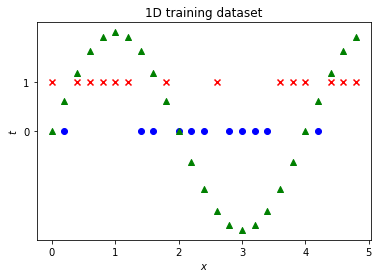

In [37]:
np.random.seed(0)

# training X, test X_test
X = np.arange(0, 5, 0.2).reshape(-1, 1)
X_test = np.arange(-2, 7, 0.1).reshape(-1, 1)

# logits a, corresponding Bernoulli t
a = np.sin(X * np.pi * 0.5) * 2
t = bernoulli.rvs(sigmoid(a))

# plot data
plt.scatter(X[t == 0], t[t == 0], marker='o', c='blue')
plt.scatter(X[t == 1], t[t == 1], marker='x', c='red')
plt.title('1D training dataset')
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.yticks([0, 1])

plt.scatter(X, a, marker='^', c='green')

Kernel: squared exponential with lengthscale theta[0] and mulitplicative constant theta[1]

In [27]:
def kernel(X1, X2, theta):
    """
    Isotropic squared exponential kernel.

    Args:
        X1: Array of m points (m x d).
        X2: Array of n points (n x d).
        theta: Kernel parameters

    Returns:
        (m x n) matrix
    """

    sqdist = np.sum(X1 ** 2, 1).reshape(-1, 1) + np.sum(X2 ** 2, 1) - 2 * np.dot(X1, X2.T)
    return theta[1] ** 2 * np.exp(-0.5 / theta[0] ** 2 * sqdist)

Helpers for matrix multiplications

In [28]:
def K_(X, theta, diag_only=False, nu=1e-5):
    """Helper to apply kernel function."""
    if diag_only:
        # Specific solution for isotropic 
        # squared exponential kernel.
        return theta[1] ** 2 + nu
    else:
        return kernel(X, X, theta) + nu * np.eye(X.shape[0])

def W_(a):
    """Helper to compute matrix W."""
    r = sigmoid(a) * (1 - sigmoid(a))
    return np.diag(r.ravel())

Implement Eq. 9 (update a) and return mode a^ of posterior p(a|t)

In [29]:
def posterior_mode(X, t, K_a, max_iter=10, tol=1e-9):
    """
    Computes the mode of posterior p(a|t).
    """
    a_h = np.zeros_like(t)
    I = np.eye(X.shape[0])

    for i in range(max_iter):
        W = W_(a_h)
        Q_inv = np.linalg.inv(I + W @ K_a)
        a_h_new = (K_a @ Q_inv).dot(t - sigmoid(a_h) + W.dot(a_h))
        a_h_diff = np.abs(a_h_new - a_h)
        a_h = a_h_new

        if not np.any(a_h_diff > tol):
            break

    return a_h

Negative log likelihood for hyperparameters, implements Eq. 14

In [30]:
def nll_fn(X, t):
    """
    Returns the negative log-likelihood function for data X, t.
    """
    
    t = t.ravel()

    def nll(theta):
        K_a = K_(X, theta)
        K_a_inv = np.linalg.inv(K_a)

        # posterior mode depends on theta (via K)
        a_h = posterior_mode(X, t, K_a).ravel()
        W = W_(a_h)

        ll = - 0.5 * a_h.T.dot(K_a_inv).dot(a_h) \
             - 0.5 * np.linalg.slogdet(K_a)[1] \
             - 0.5 * np.linalg.slogdet(W + K_a_inv)[1] \
             + t.dot(a_h) - np.sum(np.log(1.0 + np.exp(a_h)))

        return -ll

    return nll

In [31]:
res = minimize(nll_fn(X, t), [1, 1],
               bounds=((1e-3, None), (1e-3, None)),
               method='L-BFGS-B')

theta = res.x

print(f'Optimized theta = [{theta[0]:.3f}, {theta[1]:.3f}], negative log likelihood = {res.fun:.3f}')

Optimized theta = [0.715, 0.836], negative log likelihood = 17.002


predict_pt implements approximation (13) and computes class 1 probablities at inputs X_test given training data X and t. predict_a implements approximation (10) and computes the mean μa∗ and variance σ2a∗ of logits at inputs X_test.


In [34]:
def predict_a(X_test, X, t, theta):
    """
    Computes the mean and variance of logits at points X_test
    given training data X, t and kernel parameters theta.
    """
    K_a = K_(X, theta)
    K_s = kernel(X, X_test, theta)
    a_h = posterior_mode(X, t, K_a)

    W_inv = np.linalg.inv(W_(a_h))
    R_inv = np.linalg.inv(W_inv + K_a)

    a_test_mu = K_s.T.dot(t - sigmoid(a_h))
    # Compute variances only (= diagonal) instead of full covariance matrix
    a_test_var = K_(X_test, theta, diag_only=True) - np.sum((R_inv @ K_s) * K_s, axis=0).reshape(-1, 1)

    return a_test_mu, a_test_var


def predict_pt(X_test, X, t, theta):
    """
    Computes the probability of t=1 at points X_test
    given training data X, t and kernel parameters theta.
    """
    a_mu, a_var = predict_a(X_test, X, t, theta)
    kappa = 1.0 / np.sqrt(1.0 + np.pi * a_var / 8)
    return sigmoid(kappa * a_mu)

Computing class 1 probabilities at X_test gives the following output (green line), shown in context of the training data. The black dotted line represents the decision boundary at p(t∗=1∣t)=0.5.

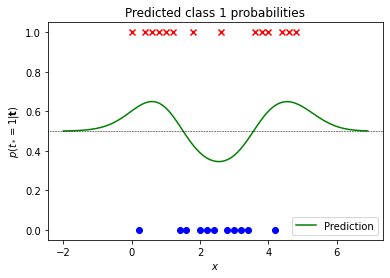

In [35]:
pt_test = predict_pt(X_test, X, t, theta)

plt.scatter(X[t == 0], t[t == 0], marker='o', c='blue')
plt.scatter(X[t == 1], t[t == 1], marker='x', c='red')
plt.plot(X_test, pt_test, label='Prediction', color='green')
plt.axhline(0.5, X_test.min(), X_test.max(), color='black', ls='--', lw=0.5)
plt.title('Predicted class 1 probabilities')
plt.xlabel('$x$')
plt.ylabel('$p(t_*=1|\mathbf{t})$')
plt.legend();